<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_11_Autoencoders_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 11. Автокодировщики. Генеративно-состязательные сети

(использованы материалы курсов [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/749635743) и https://github.com/rickwierenga/notebooks/blob/master/autoencoders.ipynb)


На этом семинаре мы изучим различные подходы к генерированию синтетических данных и рассмотрим возможные варианты их применения.

Мы будем работать со стандартным набором данных Mnist, который мы загрузим ниже.

Поскольку генеративное моделирование - задача немного сложнее, чем предсказание классов, мы также ограничим наши данные, чтобы они содержали только цифры "0" и "8".


## Подготовка данных

In [ ]:
import torch as th
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize, Pad

device = "cuda" if th.cuda.is_available() else "cpu"
print(f"Using {device} device")

train_data, test_data = [
    MNIST(
        "data", download=True,
        transform=Compose([Pad(2), ToTensor(), Normalize([0.5], [0.5])]),
        train=mode
    ) for mode in ["train", "test"]
]

train_data, test_data = [th.cat([
    data[idx][0].unsqueeze(0) for idx in range(len(data)) \
    if data[idx][1] in [0, 8]
]) for data in [train_data, test_data]]

print(
    "Loaded dataset with train/test shapes of",
    train_data.shape, test_data.shape
)
print(
    "Min/max values of train features are",
    train_data.min(), train_data.max()
)

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

def viz_images(images: th.FloatTensor, plot_title: str = "", nrow: int = 8):
    images = make_grid(images, nrow=nrow, normalize=True, value_range=(-1,1))

    plt.figure(figsize=(10,10))
    plt.title(plot_title, size=30)
    plt.axis('off')
    plt.imshow(ToPILImage()(images))

viz_images(train_data[:64], "Dataset samples");

## Генеративное моделирование

Создание шума из данных - это просто; создание данных из шума - это генеративное моделирование.

В большинстве предыдущих тем мы обсуждали возможные модели для оценки некоторой целевой переменной $y$ с учетом набора признаков $x$, или $p(y|x)$. Эта неделя будет посвящена другой схеме, когда мы хотим предсказать $x$, учитывая набор случайных признаков $z$, или $p(x|z)$. Мы предполагаем, что эти признаки $z$ (также называемые *латентными*) выбраны из известных $p(z)$.

По сравнению с проблемой обучения с учителем, здесь есть две проблемы:

1. Мы не знаем распределений между $z$ и $x$.
2. Цели $x$ являются высокоразмерными, поэтому неясно, как должна быть определена функция потерь.

Имея в виду обе эти проблемы, давайте рассмотрим несколько вариантов.


# Автокодировщики

**Автокодировщики** - это особый тип нейронных сетей. Автокодировщики похожи на классификаторы в том смысле, что они сжимают данные. Однако если классификаторы сжимают все данные изображения в одну метку, то автокодировщики сжимают данные в **латентный вектор**, часто обозначаемый в литературе $z$, с целью сохранения возможности воссоздать точно такое же изображение в будущем. Поскольку автокодировщики изучают представления, а не метки, автокодировщики относятся к обучению представлениям, подобласти машинного обучения, но не обязательно к глубокому обучению.

Воссоздание тех же данных из сжатой версии может показаться невыполнимой задачей. Однако _вы_ можете сделать то же самое. Вы, вероятно, без труда запомнили следующую последовательность:

$$1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27...$$

Наверняка вы не смотрели на каждый элемент, но вы все равно можете записать последовательность идеально, потому что вы узнали закономерность: все неровные числа, начиная с 1.

Именно этим и занимаются автокодировщики: они находят закономерности в данных.

## Архитектура
Автокодировщики состоят из двух сетей:

* Кодер (Кодировщик)
* Декодер

Цель **кодировщика** - сжать изображение, видео или любую часть данных, которые могут быть представлены в виде тензора, в _латентный вектор_. **декодер** делает, как вы уже догадались, прямо противоположное.

Чтобы максимизировать производительность, минимизировать потери, то есть, кодеры и декодеры обычно симметричны друг другу. Естественно, размер входа равен размеру выхода автокодировщика.

Автокодировщики всегда имеют меньше входных нейронов в среднем слое, чем во входном и выходном слоях. Это называется **узким местом**. Если бы не это узкое место, автокодировщики могли бы просто копировать данные с входного на выходной слой без сжатия.

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) [source](https://en.wikipedia.org/wiki/File:Autoencoder_structure.png)

## Обучение

Кодеры и декодеры _могут_ обучаться отдельно, но обычно они обучаются за один раз. Для этого кодеры складываются в один **стековый автокодировщик**.

Если вы хотите обучить Автокодировщики по отдельности, то начните с первого скрытого слоя, отбросив все остальные слои, кроме входного и выходного. На этом этапе он использует исходные данные для обучения. Затем он использует латентный вектор $z$, полученный этим мини-автокодировщиком, и обучает другой автокодировщик таким же образом, рассматривая латентные векторы как исходные данные. После достижения желаемой глубины можно сложить все выходные слои, которые предоставляли латентные векторы, вместе в один кодировщик. Этот подход не часто используется на практике, но в литературе он может упоминаться как жадное послойное обучение, поэтому полезно знать, что он означает.

## Применения

Хотя этап "поиск закономерностей" может показаться не очень интересным, существует множество захватывающих применений автокодировщиков. Сегодня мы рассмотрим три из них:

1. Плотный автокодировщик: сжатие данных.
2. Конволюционный автокодировщик: строительный блок DCGANs, самоконтролируемое обучение.
3. Автокодировщик для удаления шума из плохих обучающих данных.

Хотя все эти приложения используют поиск закономерностей, они имеют разные случаи применения, что делает автокодировщики одной из самых интересных тем машинного обучения.

Интуитивно мы можем моделировать $p(x|z)$ с помощью обучаемой сети $g_{\theta}(z)$ (назовем ее "декодером"), и рассматривать упрощенные L2 или L1 потери как наши конечные цели.

Но как быть с первой проблемой?

Автокодировщики решают ее с помощью отдельной "кодирующей" сети $f_{\psi}(x)$, которая предсказывает "оптимальный" латентный $z$ с учетом $x$, т.е. пытается явно смоделировать $p(z|x)$.

Это дает нам следующую цель обучения:

$\mathcal{L}(\theta, \psi) = \sum_{i=1}^N\|g_\theta(f_\psi(x_i)) - x_i\|_2^2$, где $\{x_i\}_{i=1}^N$ - набор реальных изображений для обучения.

Давайте проверим, как эта модель работает на нашем наборе данных.




In [ ]:
from typing import List
import torch.nn as nn


class Reshape(nn.Identity):
    def __init__(self, spatial_shapes: List) -> None:
        super().__init__()
        self._spatial_shapes = spatial_shapes

    def forward(self, x: th.Tensor) -> th.Tensor:
        return x.view(x.size(0), *self._spatial_shapes)


def get_conv_encoder_network(
    base_channels: int = 32,
    num_layers: int = 3,
    latent_dim: int = 4,
    input_channels: int = 1
) -> nn.Module:
    """An example of Encoder.
    It has an architecture
    Conv -> ReLU -> Conv -> ReLU -> ...

    Note that in every odd convolution, we downsample the spatial dimensions
        by a factor of 2 and simultaneously increase the amount of features.
    """
    ic, ch = input_channels, base_channels
    module_list = []
    for _ in range(num_layers):
        module_list.append(
            nn.Conv2d(ic, ch, kernel_size=3, stride=2, padding=1)
        )
        module_list.append(nn.ReLU())
        ic = ch
        ch = ic * 2
    #module_list.append(nn.AdaptiveAvgPool2d(4))
    module_list.append(Reshape([-1]))
    module_list.append(nn.Linear(ic * 4 * 4, latent_dim))

    return nn.Sequential(*module_list)

@th.no_grad() # disable gradient accumulations
def report_shapes(model: nn.Module, state: th.Tensor) -> None:
    model.eval()
    print("Input:", state.shape)
    for i, layer in enumerate(model.children()):
        state = layer(state)
        print("Layer %d:" % i, state.shape)
    print("Output:", state.shape)

E = get_conv_encoder_network(32).to(device)
print("Encoder architecture:", E)
print("Num params:", sum([p.numel() for p in E.parameters()]))
print('-'*40)
print("Shapes during computation with batch_size = 3:")
report_shapes(E, train_data[:3].to(device))

In [ ]:
32*32

В нашей архитектуре кодера мы в значительной степени полагались на сверточные слои.

Мы уже знаем, что свертка со отступами ("stride") уменьшает размерность изображения, что удобно при генерации изображений, особенно потому, что позволяет нам "объединить" информацию из многих пространственных мест в сети.


Однако в случае автокодировщиков мы должны как-то "переделать" эффект свертки, что позволило бы нам увеличить пространственное разрешение изображения.

Для этого мы будем использовать Transposed Convolutions. Их поведение и сравнение со стандартными свертками показано на трех рисунках ниже (взяты с сайтов https://github.com/vdumoulin/conv_arithmetic и https://arxiv.org/abs/1609.07009).

1D визуализации:

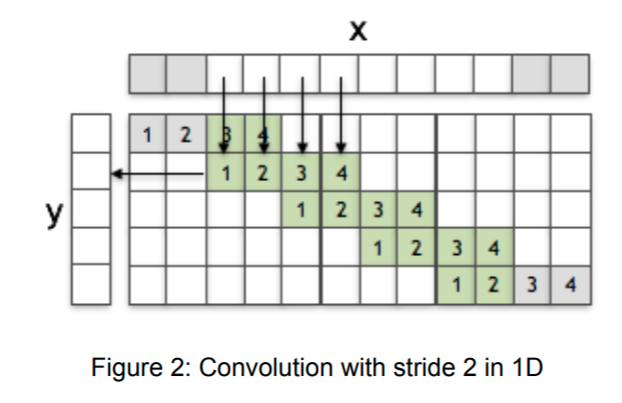

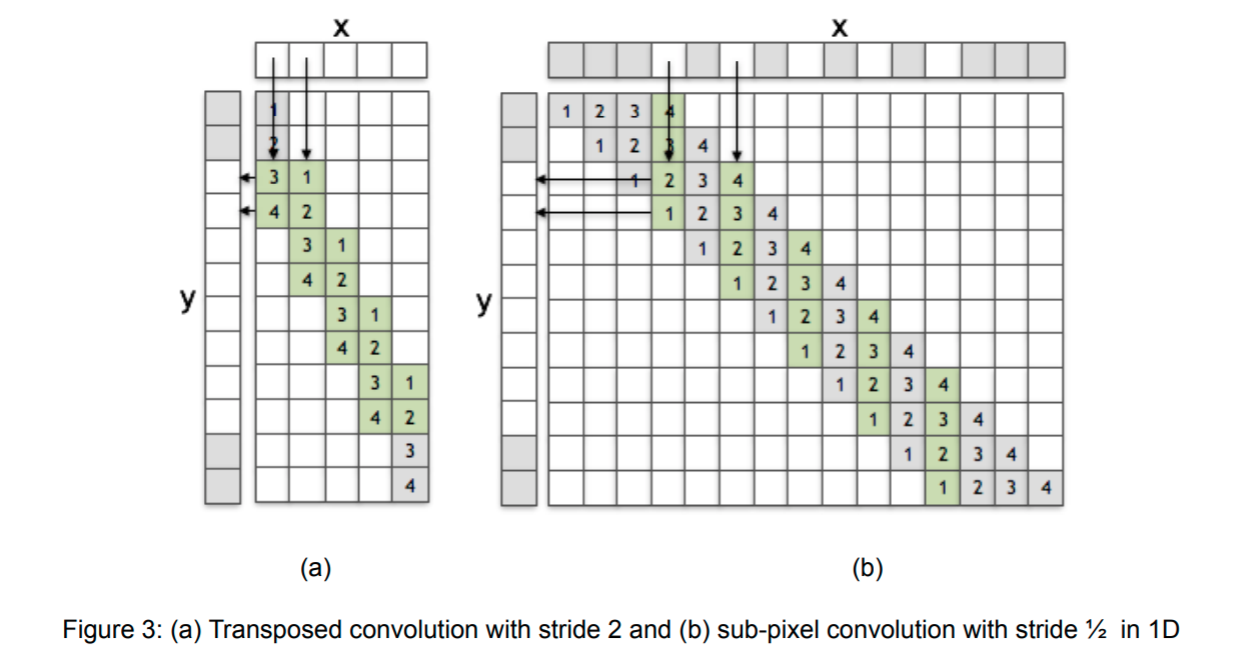

2D визуализация (ConvTranspose with padding = stride = 0):

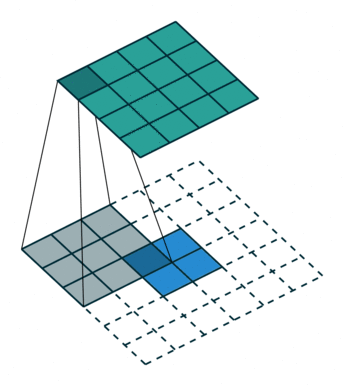

In [ ]:
def get_conv_decoder_network(
    base_channels: int = 32,
    num_layers: int = 3,
    latent_dim: int = 4,
    output_channels: int = 1
) -> nn.Module:
    """An example of Decoder.
    It mirrors the architecture of Encoder, where upsampling is performed
        by using Transposed Convolutions.
    """
    ch = base_channels * 2 ** (num_layers - 1)
    module_list = [nn.Linear(latent_dim, ch * 4 * 4)]
    module_list.append(nn.ReLU())
    module_list.append(Reshape([ch, 4, 4]))
    for _ in range(num_layers):
        module_list.append(
            nn.ConvTranspose2d(
                ch, ch // 2, kernel_size=3, stride=2,
                padding=1, output_padding=1
            )
        )
        module_list.append(nn.ReLU())
        ch = ch // 2
    module_list.append(
        nn.Conv2d(
            ch, output_channels, kernel_size=1
        )
    )
    return nn.Sequential(*module_list)

D = get_conv_decoder_network(32).to(device)
print("Decoder architecture:", D)
print("Num params:", sum([p.numel() for p in D.parameters()]))
print('-'*40)
print("Shapes during computation with batch_size = 3:")
report_shapes(D, E(train_data[:3].to(device)))

In [ ]:
from typing import Tuple


class AutoEncoder(nn.Module):
    def __init__(
        self, encoder: nn.Module, decoder: nn.Module,
        latent_dim: Tuple[int, int, int]
    ) -> None:
        """A convenient wrapper for Encoder-Decoder joint training.

        Requires exact latent dimensionality shape, which can be infered
            from "report_shapes" call.
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def forward(self, x: th.Tensor) -> th.Tensor:
        z = self.encoder(x)
        return self.decoder(z)

    def get_train_loss(
        self, model_output: th.Tensor, data: th.Tensor
    ) -> th.Tensor:
        #return th.sum((model_output - data) ** 2) / data.size(0)
        return th.nn.functional.mse_loss(
            model_output, data, reduction="sum"
        ) / data.size(0)

    @th.no_grad() # disable gradient accumulation during evaluation
    def sample(self, z: th.Tensor) -> th.Tensor:
        assert self.decoder.training is False, "Please, put D in eval mode"
        # make sure model samples are in desired range [-1, 1]
        return self.decoder(z).clamp(-1, 1)

    @th.no_grad()
    def reconstruct(self, x: th.Tensor) -> th.Tensor:
        assert self.decoder.training is False, "Please, put D in eval mode"
        assert self.encoder.training is False, "Please, put G in eval mode"
        return self.decoder(self.encoder(x))


def train(
    epoch: int, model: nn.Module,
    loader: th.utils.data.DataLoader, optimizer: th.optim.Optimizer
) -> None:
    """Utility function for model training."""
    model.train()
    for batch_idx, data in enumerate(loader):
        # send to device
        data = data.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = model.get_train_loss(output, data)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))


E = get_conv_encoder_network(32).to(device)
D = get_conv_decoder_network(32).to(device)
# automatically infer latent dim
latent_dim = list(E(train_data[:2].to(device)).shape[1:])
autoencoder = AutoEncoder(E, D, latent_dim).to(device)

optimizer = th.optim.Adam(autoencoder.parameters(), lr=1e-3)
train_loader = th.utils.data.DataLoader(
    train_data, batch_size=128, shuffle=True
)

for epoch in range(10):
    train(epoch, autoencoder, train_loader, optimizer)

In [ ]:
autoencoder.eval()
reconstructions = autoencoder.reconstruct(train_data[:8].cuda()).cpu()
viz_images(
    th.cat([train_data[:8], reconstructions]),
    "Top: original; Bottom: reconstruction"
);

Реконструкции выглядят хорошо!

Теперь проверим синтетические образцы:

In [ ]:
def get_samples(
    model: nn.Module, num_samples: int = 64, batch_size: int = 64
) -> th.Tensor:
    """Draw samples from a trained decoder"""
    model.eval()
    samples = th.zeros([num_samples, 1, 32, 32])
    for idx in range(num_samples // batch_size):
        z = th.randn([batch_size] + model.latent_dim).to(device)
        x_hat = model.sample(z)
        samples[idx * batch_size: idx * batch_size + batch_size] = x_hat
    return samples

fake_samples = get_samples(autoencoder)
viz_images(fake_samples, "Synthetic samples");

Почему они выглядят такими случайными?

Это естественная проблема автокодировщиков - хотя они вроде бы хорошо восстанавливают даже тестовые данные, на самом деле мы не знаем распределения латентных переменных, из которых мы должны сделать выборку, чтобы получить что-то **похожее** на реальные изображения, но на самом деле не является одним из них.

Одна из простых идей, как это исправить - ввести некоторую форму регуляризации потерь, которая гарантирует, что $q(z|x)$ соответствует некоторому известному распределению $p(z)$.

### Вариационные автокодировщики


VAE является расширением модели автокодировщика. Вместо простой аппроксимации $p(z|x)$ без дополнительных ограничений, мы используем следующие потери:

$\mathcal{L}(\theta, \psi) = \sum_{i=1}^N\mathbb{E}_{z\sim\mathcal{N}(\mu_{\psi}(x_i), \sigma_{\psi}(x_i))}\|g_\theta(z) - x_i\|_2^2+\mathbb{KL}[\mathcal{N}(\mu_{\psi}(x_i), \sigma_{\psi}(x_i)) \| \mathcal{N}(0, I)]$,

где $\{x_i\}_{i=1}^N$ - набор реальных обучающих изображений, $\mu_{\psi}(x_i), \sigma_{\psi}(x_i)$ - предсказание латентных средних и std параметров, полученных от обучаемой кодирующей сети $f_{\psi}(x_i)$, а $\mathbb{KL}$ - расстояние [KL-дивергенции](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9A%D1%83%D0%BB%D1%8C%D0%B1%D0%B0%D0%BA%D0%B0_%E2%80%94_%D0%9B%D0%B5%D0%B9%D0%B1%D0%BB%D0%B5%D1%80%D0%B0) между предсказанным и желаемым распределениями.

Мы можем дополнительно упростить эту задачу, если проигнорируем предсказание $\sigma_{\psi}(x_i)$ и сосредоточимся исключительно на среднем. В этом случае задача преобразуется в:

$\mathcal{L}(\theta, \psi) = \sum_{i=1}^N\|g_\theta(f_\psi(x_i)) - x_i\|_2^2+\|f_\psi(x_i)\|_2^2.$

Обратите внимание, что это отличается от того, что мы имели раньше, только введением регуляризирующего члена на латентных предсказаниях $f_{\psi}(x_i)$. В некотором смысле, мы заставляем наши модели "держать разные выборки вместе".

В более общем случае с сигмой удобно использовать так называемый ["трюк перепараметризации"](https://gregorygundersen.com/blog/2018/04/29/reparameterization/).

Теперь давайте попробуем реализовать эту более продвинутую модель.

In [ ]:
class VariationalAutoEncoder(AutoEncoder):
    """
    Inherit our base AutoEncoder functionality, but override forward
        and get_train_loss methods s.t. we get a VAE model
    """
    def forward(self, x: th.Tensor) -> th.Tensor:
        # split eight dimensions - first four go to mean, rest is logvar
        z_mean, z_logvar = self.encoder(x).chunk(2, dim=1)
        # ensure that predicted sigma is always positive
        z_std = th.exp(0.5 * z_logvar)
        # perform reparameterization trick to sample z from the encoder distr
        z = z_mean + th.randn_like(z_mean).to(z_mean.device) * z_std
        return self.decoder(z), z_mean, z_logvar

    def get_train_loss(
        self, model_output: th.Tensor, data: th.Tensor
    ) -> th.Tensor:
        x_hat, z_mean, z_logvar = model_output

        reconstruction_loss = super().get_train_loss(x_hat, data)
        # KL divergence loss to regularize encoder distr
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        regularization_loss = -0.5 * th.sum(
            1 + z_logvar - z_mean.pow(2) - z_logvar.exp()
        ) / data.size(0)
        return reconstruction_loss + regularization_loss

    @th.no_grad()
    def reconstruct(self, x: th.Tensor) -> th.Tensor:
        assert self.decoder.training is False, "Please, put D in eval mode"
        assert self.encoder.training is False, "Please, put G in eval mode"
        # reconstruct using mean only
        return self.decoder(self.encoder(x).chunk(2, dim=1)[0])

E = get_conv_encoder_network(32, latent_dim=8).to(device)
D = get_conv_decoder_network(32).to(device)

vae = VariationalAutoEncoder(E, D, latent_dim).to(device)
optimizer = th.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(10):
    train(epoch, vae, train_loader, optimizer)

In [ ]:
vae.eval()
reconstructions_vae = vae.reconstruct(train_data[:8].cuda()).cpu()

viz_images(
    th.cat([train_data[:8], reconstructions_vae]),
    "Top: original; Bottom: reconstruction"
);

In [ ]:
fake_samples_vae = get_samples(vae)
viz_images(fake_samples_vae, "Synthetic VAE samples");

Мы видим, что наши образцы гораздо лучше похожи на истину. Обусловлены ли эти преимущества уменьшением скрытой размерности кодировщика на $2x$?

### Генеративно-состязательные сети (GAN)

Автоэнкодеры выглядят естественным выбором, если мы знаем, какая функция потерь может быть использована для сравнения наших реконструкций модели с истиной.

Но что если нет?

Кроме того, несмотря на то, что VAE частично решают проблему выборки, мы по-прежнему получаем проблему **латентного несоответствия**, поскольку распределение входных данных, которые декодер получает во время обучения, не совсем совпадает с распределением во время выборки (одно является нормальным распределением с предсказанным средним/std, другое - стандартным нормальным распределением).

Генеративно-состязательные сети (GAN) пытаются получить более релевантную для восприятия метрику, вводя форму игры между двумя сетями, называемыми генератором ($G$) и дискриминатором ($D$).

В этой игре $G$ получает случайный шум из точно стандартного нормального распределения $p(z)$ и предсказывает некоторое изображение $\hat{x} \sim q(x|z)$.

Затем, $D$ учится отличать реальное $x$ от поддельного $\hat{x}$ изображения, а $G$ учится обманывать его. Обе цели оптимизируются чередующимся способом - мы делаем один шаг обучения для $D$ с замороженным $G$, а затем один шаг для $G$ с замороженным $D$, и этот цикл повторяется в течение многих шагов.

Существует множество возможных целей для $D$ и $G$ - в примере ниже мы используем [наименьшие квадраты](https://paperswithcode.com/method/lsgan).

In [ ]:
from typing import Optional


class GenerativeAdversarialNetwork(nn.Module):
    def __init__(
        self, generator: nn.Module, discriminator: nn.Module,
        latent_dim: Tuple[int, int, int]
    ) -> None:
        """A convenient wrapper for Generator-Discriminator joint training.

        Requires exact latent dimensionality shape, which can be infered
            from "report_shapes" call.
        """
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def forward_generator(self, z: th.Tensor) -> th.Tensor:
        return self.generator(z)

    def forward_discriminator(
        self, x_fake: th.Tensor, x_real: Optional[th.Tensor] = None
    ) -> th.Tensor:
        fake_scores = self.discriminator(x_fake)
        if x_real is not None:
            real_scores = self.discriminator(x_real)
            return fake_scores, real_scores
        else:
            return fake_scores

    def get_train_loss_generator(
        self, fake_scores: th.Tensor
    ) -> th.Tensor:
        return (fake_scores - 1).pow(2).mean()

    def get_train_loss_discriminator(
        self, fake_scores: th.Tensor, real_scores: th.Tensor
    ) -> th.Tensor:
        return (real_scores - 1).pow(2).mean() + (fake_scores - 0).pow(2).mean()

    @th.no_grad() # disable gradient accumulation during evaluation
    def sample(self, z: th.Tensor) -> th.Tensor:
        assert self.generator.training is False, "Please, put D in eval mode"
        # make sure model samples are in desired range [-1, 1]
        return self.generator(z).clamp(-1, 1)


G = get_conv_decoder_network(32, latent_dim=16).to(device)
D = get_conv_encoder_network(32, latent_dim=1).to(device)

gan = GenerativeAdversarialNetwork(G, D, latent_dim=[16])
gan

In [ ]:
def train_gan(
    epoch: int, model: nn.Module,
    loader: th.utils.data.DataLoader,
    G_optimizer: th.optim.Optimizer,
    D_optimizer: th.optim.Optimizer
) -> None:
    """Utility function for model training."""
    model.train()
    for batch_idx, data in enumerate(loader):
        # prepare ground truth data
        data = data.to(device)
        # prepare latent noise
        z = th.randn([data.size(0)] + model.latent_dim).to(device)

        """1. Get generator samples"""
        x_fake = model.forward_generator(z)

        """2. Train Discriminator (note that we disable gradients through G)"""
        D_optimizer.zero_grad()
        D_fake, D_real = model.forward_discriminator(x_fake.detach(), data)
        D_loss = model.get_train_loss_discriminator(D_fake, D_real)
        D_loss.backward()
        D_optimizer.step()

        """3. Train Generator"""
        G_optimizer.zero_grad()
        D_fake = model.forward_discriminator(x_fake)
        G_loss = model.get_train_loss_generator(D_fake)
        G_loss.backward()
        G_optimizer.step()

    print(
        'Train Epoch: {}\tDiscriminator Loss: {:.6f}\tGenerator Loss: {:.6f}'.format(
            epoch, D_loss.item(), G_loss.item()
        )
    )


G = get_conv_decoder_network(32, latent_dim=16).to(device)
D = get_conv_encoder_network(32, latent_dim=1).to(device)

gan = GenerativeAdversarialNetwork(G, D, latent_dim=[16])

G_optimizer = th.optim.Adam(gan.generator.parameters(), lr=1e-3)
D_optimizer = th.optim.Adam(gan.discriminator.parameters(), lr=1e-3)

for epoch in range(10):
    train_gan(epoch, gan, train_loader, G_optimizer, D_optimizer)

In [ ]:
fake_samples_gan = get_samples(gan)
viz_images(fake_samples_gan, "Synthetic GAN samples");

Результаты выглядят неестественно, и что еще хуже - они выглядят очень близко друг к другу, что называется проблемой **модального коллапса**. Это частая проблема для GAN.

Ниже мы попытаемся решить эту проблему с помощью ряда модификаций.

## Архитектуры: Как повысить дискретизацию, слои нормализации

В нашем предыдущем примере мы пытались просто повторно использовать архитектуру кодировщика в качестве дискриминатора и декодера в качестве генератора.

С этим есть несколько проблем:

1. Состязательное обучение не очень стабильно по сравнению с простой задачей MSE.
2. Наш генератор $G$ обучается на основе выходов дискриминатора $D$, который содержит множество функций нелинейности ReLU. Из-за этого градиенты $D$ относительно входа могут содержать много нулей, и генератор может получить исчезающие градиенты.
3. Наш существующий метод повышения дискретизации в $G$ с транспонированными свертками обычно приводит к некоторым нежелательным артефактам [checkerboard artifacts](https://distill.pub/2016/deconv-checkerboard/).


Мы решаем первую проблему путем введения слоев BatchNorm как в $G$, так и в $D$. Вторая проблема решается путем замены функций нелинейности ReLU на [LeakyReLU](https://paperswithcode.com/method/leaky-relu), которая имеет некоторые градиенты, даже когда ее входные данные меньше нуля. Наконец, проблема с ConvTranspose решена путем замены их на nearest upsampling + оригинальный слой Conv, как было предложено авторами выше.

И последнее, но не менее важное: мы увеличиваем сложность нашей модели и втрое увеличиваем время ее обучения.

In [ ]:
class Upsample(nn.Identity):
    """A novel upsampling layer that replaces ConvTranspose2d"""
    def __init__(self, scale_factor: int) -> None:
        super().__init__()
        self._scale_factor = scale_factor

    def forward(self, x: th.Tensor) -> th.Tensor:
        return th.nn.functional.interpolate(
            x, scale_factor=self._scale_factor, mode='nearest'
        )

In [ ]:
def get_conv_generator_network(
    base_channels: int = 64,
    num_layers: int = 3,
    latent_dim: int = 100,
    output_channels: int = 1
) -> nn.Module:
    """An example of Generator architecture derived from Decoder.
    We replace ConvTranspose2d with Nearest upsampling + Conv2d,
    add Batch normalization layers and increase model depth
    """
    ch = base_channels * 2 ** (num_layers - 1)

    module_list = [nn.Linear(latent_dim, latent_dim * 4 * 4)]
    module_list.append(Reshape([latent_dim, 4, 4]))
    module_list.append(
        nn.Conv2d(latent_dim, ch, kernel_size=3, padding=1, bias=False)
    )
    module_list.append(nn.BatchNorm2d(ch))
    module_list.append(nn.ReLU())

    for _ in range(num_layers):
        module_list.append(
            Upsample(2)
        )
        module_list.append(
            nn.Conv2d(ch, ch // 2, kernel_size=3, padding=1, bias=False)
        )
        module_list.append(nn.BatchNorm2d(ch // 2))
        module_list.append(nn.ReLU())
        ch = ch // 2
    module_list.append(
        nn.Conv2d(
            ch, output_channels, kernel_size=1
        )
    )
    return nn.Sequential(*module_list)


G = get_conv_generator_network(64).to(device)
print("Encoder architecture:", G)
print("Num params:", sum([p.numel() for p in G.parameters()]))
print('-'*40)
print("Shapes during computation with batch_size = 3:")
report_shapes(G, th.randn([64, 100]).to(device))


In [ ]:
def get_conv_discriminator_network(
    base_channels: int = 32,
    num_layers: int = 4,
    input_channels: int = 1
) -> nn.Module:
    """An example of a Discriminator arch.
    It has an architecture
    Conv -> ReLU -> Conv -> ReLU -> ...

    Note that in every odd convolution, we downsample the spatial dimensions
        by a factor of 2 and simultaneously increase the amount of features.
    """
    ic, ch = input_channels, base_channels
    module_list = []
    for i in range(num_layers):
        module_list.append(
            nn.Conv2d(ic, ch, kernel_size=4, stride=2, padding=1, bias=False)
        )
        if i > 0:
            module_list.append(nn.BatchNorm2d(ch))
        module_list.append(nn.LeakyReLU(0.2))
        ic = ch
        ch = ic * 2
    module_list.append(nn.AdaptiveAvgPool2d(1))
    module_list.append(Reshape([-1]))
    module_list.append(nn.Linear(ic, 1))

    return nn.Sequential(*module_list)

D = get_conv_discriminator_network(32).to(device)
print("Discriminator architecture:", D)
print("Num params:", sum([p.numel() for p in D.parameters()]))
print('-'*40)
print("Shapes during computation with batch_size = 3:")
report_shapes(D, train_data[:3].to(device))

In [ ]:
G = get_conv_generator_network(64).to(device)
D = get_conv_discriminator_network(32).to(device)

gan = GenerativeAdversarialNetwork(G, D, latent_dim=[100])
print(gan)

G_optimizer = th.optim.Adam(gan.generator.parameters(), lr=2e-4)
D_optimizer = th.optim.Adam(gan.discriminator.parameters(), lr=2e-4)

for epoch in range(30):
    train_gan(epoch, gan, train_loader, G_optimizer, D_optimizer)

In [ ]:
# Leaky ReLU
fake_samples_gan = get_samples(gan)
viz_images(fake_samples_gan, "Synthetic GAN samples");

In [ ]:
fake_samples_gan = get_samples(gan)
viz_images(fake_samples_gan, "Synthetic GAN samples");

## Метрики: Precision/Recall, Frechet Inception Distance



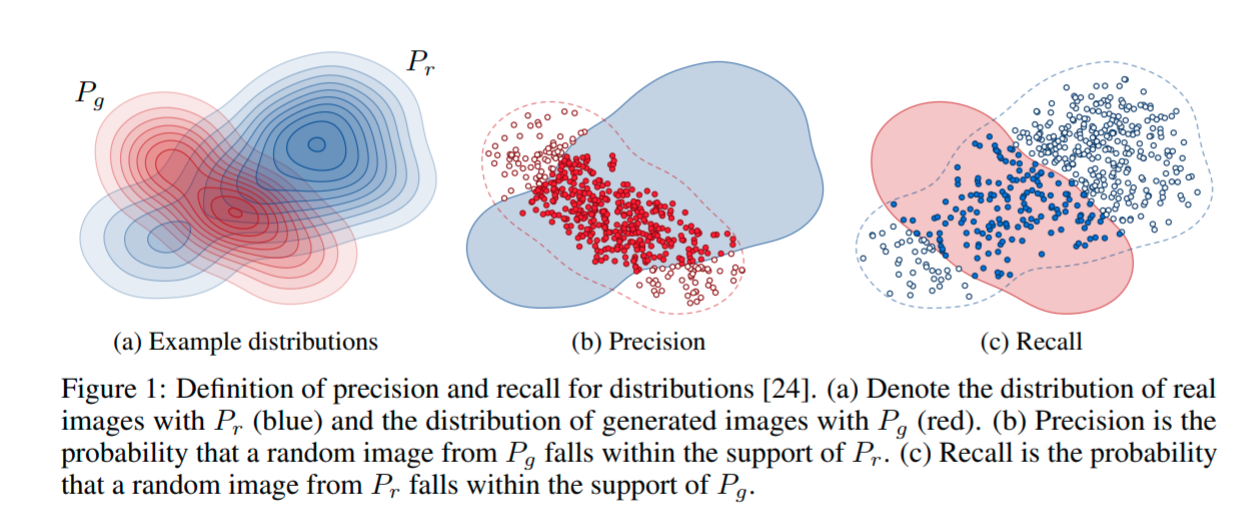

# Виды и модификации GAN


## WGAN

Потери Вассерштейна

Эта функция потерь зависит от модификации схемы GAN (называемой "Wasserstein GAN" или "WGAN"), в которой дискриминатор фактически не классифицирует экземпляры. Для каждого экземпляра он выдает число. Это число не обязательно должно быть меньше единицы или больше 0, поэтому мы не можем использовать 0,5 в качестве порога, чтобы решить, является ли экземпляр настоящим или поддельным. При обучении дискриминатора мы просто пытаемся сделать так, чтобы выходное число для настоящих экземпляров было больше, чем для фальшивых.

Поскольку он не может действительно различать настоящие и поддельные экземпляры, дискриминатор WGAN называют "критиком", а не "дискриминатором". Это различие имеет теоретическое значение, но для практических целей мы можем рассматривать его как признание того, что входные данные для функций потерь не обязательно должны быть вероятностями.

Сами функции потерь обманчиво просты:

Critic Loss: $D(x) - D(G(z))$.

Дискриминатор пытается максимизировать эту функцию. Другими словами, он пытается максимизировать разницу между своим результатом на реальных экземплярах и результатом на поддельных экземплярах.

Generator Loss: $D(G(z))$

Генератор пытается максимизировать эту функцию. Другими словами, он пытается максимизировать выход дискриминатора для поддельных экземпляров.

В этих функциях:

$D(x)$ - выход критика для реального экземпляра.
$G(z)$ - выход генератора при заданном шуме $z$.
$D(G(z))$ - выход критика для поддельного экземпляра.
Выход критика $D$ не обязательно должен быть между 1 и 0.
Формулы получены из расстояния между реальным и сгенерированным распределениями.

Требования
Теоретическое обоснование Wasserstein GAN (или WGAN) требует, чтобы веса в GAN были обрезаны так, чтобы они оставались в ограниченном диапазоне.

Преимущества
GAN Вассерштейна менее подвержены опасности застревания, чем GAN на основе минимакса, и избегают проблем с исчезающими градиентами. Преимущество расстояния земного шара состоит в том, что оно является настоящей метрикой: мерой расстояния в пространстве вероятностных распределений. Перекрестная энтропия не является метрикой в этом смысле.

## Cramer GAN

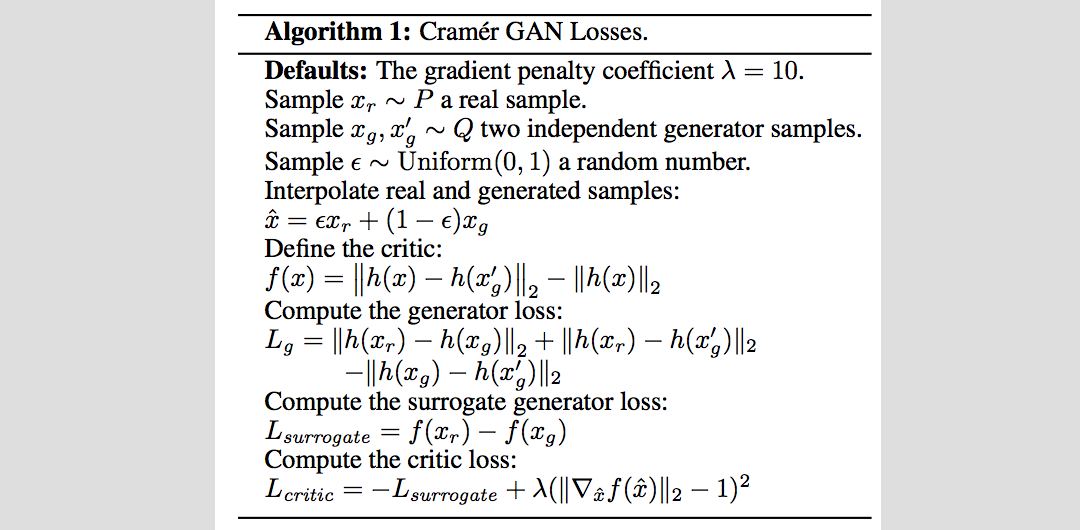